In [1]:
!apt-get install espeak

Reading package lists... Done
Building dependency tree       
Reading state information... Done
espeak is already the newest version (1.48.04+dfsg-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [2]:
!pip install Soundfile pydub

In [0]:
import numpy as np
import subprocess
import os
import sys
from pydub import AudioSegment

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
consonants = ['','b', 'br','c', 'cr','d', 'dr','f', 'fr','g', 'gr','j','l', 'lh','m','n', 'nh','p','pr','qu','r','s','t', 'tr','v','vr','x','z']
vowels = ['a','e','i','o','u']
suffixes = ['', 's', 'r', 'l', 'm']
def generate_syllables(n=-1):
  while(n!=0):
    yield ''.join([np.random.choice(x) for x in [consonants,vowels,suffixes]])
    n-=1

def generateAllSyllables(pattern='cvs'):
  for c in ('c' in pattern) and consonants or ['']:
    for v in ('v' in pattern) and vowels or ['']:
      for s in ('s' in pattern) and suffixes or ['']:
        yield c+v+s

def saveSound(word, dir):
  p = subprocess.Popen(['espeak','-v', 'pt-br', word, '--stdout'], bufsize=-1, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  out, _ = p.communicate()
  with open(os.path.join(dir, word)+'.wav', 'wb') as f:
    f.write(out)


In [0]:
datasetdir = 'datasets/speech/syllables/'
for i in ['v', 'cv', 'cvs']:
  os.makedirs(datasetdir+i,exist_ok=True)
  for j in generateAllSyllables(i):
    saveSound(j, datasetdir+i)

In [7]:
!ls {datasetdir}/*

datasets/speech/syllables//cv:
a.wav	 cre.wav  fa.wav   gri.wav  lhu.wav  ni.wav   qui.wav  to.wav	vru.wav
ba.wav	 cri.wav  fe.wav   gro.wav  li.wav   no.wav   quo.wav  tra.wav	vu.wav
be.wav	 cro.wav  fi.wav   gru.wav  lo.wav   nu.wav   quu.wav  tre.wav	xa.wav
bi.wav	 cru.wav  fo.wav   gu.wav   lu.wav   o.wav    ra.wav   tri.wav	xe.wav
bo.wav	 cu.wav   fra.wav  i.wav    ma.wav   pa.wav   re.wav   tro.wav	xi.wav
bra.wav  da.wav   fre.wav  ja.wav   me.wav   pe.wav   ri.wav   tru.wav	xo.wav
bre.wav  de.wav   fri.wav  je.wav   mi.wav   pi.wav   ro.wav   tu.wav	xu.wav
bri.wav  di.wav   fro.wav  ji.wav   mo.wav   po.wav   ru.wav   u.wav	za.wav
bro.wav  do.wav   fru.wav  jo.wav   mu.wav   pra.wav  sa.wav   va.wav	ze.wav
bru.wav  dra.wav  fu.wav   ju.wav   na.wav   pre.wav  se.wav   ve.wav	zi.wav
bu.wav	 dre.wav  ga.wav   la.wav   ne.wav   pri.wav  si.wav   vi.wav	zo.wav
ca.wav	 dri.wav  ge.wav   le.wav   nha.wav  pro.wav  so.wav   vo.wav	zu.wav
ce.wav	 dro.wav  gi.wav   lha.wav  nhe.wav  pru.

In [0]:
import numpy as np
import soundfile

def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = np.lib.stride_tricks.as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

In [0]:
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

out_chars = 'abcdefghijklmnopqrstuvwxyz '
chars_to_ix = dict(zip(out_chars,range(len(out_chars))))
ix_to_chars = dict(zip(range(len(out_chars)),out_chars))

def ctc_loss(y_shape):
  def f(y_true, y_pred):
    y_true = tf.reshape(y_true, y_shape)
    k_inputs = y_pred
    k_input_lens = y_true[:,0:1]
    k_label_lens = y_true[:,1:2]
    k_labels = y_true[:,2:]
    cost = K.ctc_batch_cost(k_labels, k_inputs, k_input_lens,k_label_lens)
    return cost
  return f

def to_ctc_format(xs,ys, max_ty=None):
  max_tx = np.max([len(i) for i in xs])
  if max_ty == None:
    max_ty = np.max([len(i) for i in ys]) + 3
  assert max_ty >= np.max([len(i) for i in ys]) + 3
  xarr = np.zeros((len(xs), max_tx, xs[0].shape[1]))
  yarr = np.zeros((len(ys), max_ty))
  for i, x in enumerate(xs):
    xarr[i,:len(x)] = x
  for i, y in enumerate(ys):
    yarr[i,:len(y)+2] = [len(x), len(y), *y]
  return xarr, yarr

def from_ctc_format(ys):
  ixss = [y[2:][:int(y[1])] for y in ys]
  return [''.join([ix_to_chars[ix] for ix in ixs]) for ixs in ixss]



def ctc_predict(model, xarr):
  y_pred = model.predict(xarr)
  pred = ctc_decode(y_pred)
  pred = K.eval(pred)
  return [''.join([ix_to_chars[i] for i in p if i>-1]) for p in pred]

def ctc_decode(y_pred):
  input_length = K.variable(np.ones((y_pred.shape[0],), dtype=np.int32)*y_pred.shape[1])

  pred, log_pred = K.ctc_decode(
    y_pred,
    input_length,
    beam_width=50,
    top_paths=1)
  return pred[0]


In [0]:
def examples_from(folder):
    def inner():
        for dirpath, dirnames, filenames in os.walk(folder):
            for f in filenames:
                yield os.path.join(dirpath, f)
    return list(inner())

In [0]:
examples = examples_from(datasetdir + 'v')

In [12]:
examples

['datasets/speech/syllables/v/a.wav',
 'datasets/speech/syllables/v/o.wav',
 'datasets/speech/syllables/v/e.wav',
 'datasets/speech/syllables/v/u.wav',
 'datasets/speech/syllables/v/i.wav']

In [0]:
def category_from_name(path):
    return os.path.basename(path).rsplit('.',1)[0]
  
def xs_ys_from_filenames(filenames, max_ty):
    xs = []
    ys = []
    for f in filenames:
        y = category_from_name(f)
        y = [chars_to_ix[j] for j in y]
        x = spectrogram_from_file(f)
        xs.append(x)
        ys.append(y)
    xs, ys = to_ctc_format(xs, ys, max_ty)
    return xs, ys

In [0]:
xs, ys =xs_ys_from_filenames(examples, max_ty=100)

In [15]:
xs.shape, ys.shape

((5, 48, 221), (5, 100))

In [0]:
import matplotlib.pyplot as plt

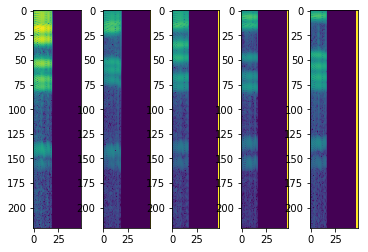

In [17]:
for i in range(5):
  plt.subplot(151+i)
  plt.imshow(xs[i].T)


In [0]:
last = l0 = tf.keras.layers.Input(shape=(None,221))
last = l1 = tf.keras.layers.Conv1D(16, (3,), padding="same", activation="relu")(last)
last = l2 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
# last = l3 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
last = l4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(last)
# last = l5 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
# last = l6 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
# last = l7 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
last = l8 = tf.keras.layers.Conv1D(4, (3,), padding="same", activation="relu")(last)
last = l9 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(last)
last =l10 = tf.keras.layers.LSTM(64, return_sequences=True)(last)
last = l11 = tf.keras.layers.Dense(27)(last)
last = l12 = tf.keras.layers.Activation('softmax')(last)

model = tf.keras.Model([l0], last)
model.compile(loss=ctc_loss((5, 100)),
        optimizer=tf.keras.optimizers.Adam())

In [0]:
import tensorflow.keras.backend as K

In [60]:
def forward(last):
  last = l1 = tf.keras.layers.Conv1D(16, (3,), padding="same", activation="relu")(last)
  last = l4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(last)
  last = l2 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
  last = l4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(last)
  last = l3 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
  last = l4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(last)
  last = l5 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
  last = l4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(last)
  last = l6 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
  last = l4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(last)
  last = l7 = tf.keras.layers.Conv1D(8, (3,), padding="same", activation="relu")(last)
  last = l4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(last)
  last = l8 = tf.keras.layers.Conv1D(4, (3,), padding="same", activation="relu")(last)
  last = l9 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(last)
  last =l10 = tf.keras.layers.LSTM(64, return_sequences=True)(last)
  last = l11 = tf.keras.layers.Dense(27)(last)
  last = l12 = tf.keras.layers.Activation('softmax')(last)
  return last
last = np.array(xs, dtype='float32')
last = forward(last)
last.shape

TensorShape([Dimension(5), Dimension(21), Dimension(27)])

In [0]:
l0 = tf.keras.layers.Input(shape=(None,221))
model = tf.keras.Model(l0, layers(l0))
model.compile(loss=ctc_loss((5, 100)),
        optimizer=tf.keras.optimizers.Adam())

In [0]:
last = np.array(xs, dtype='float32')

In [0]:
y_pred = forward(last)

In [69]:
ys.shape, y_pred.shape

((5, 100), TensorShape([Dimension(5), Dimension(21), Dimension(27)]))

In [0]:
ctcloss = ctc_loss((5,100))

In [71]:
ctcloss(ys, y_pred)

InvalidArgumentError: ignored

In [77]:
ys

array([[46.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [46.,  1., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [78]:
y_true = ys
k_inputs = y_pred
k_input_lens = y_true[:,0:1]
k_label_lens = y_true[:,1:2]
k_labels = y_true[:,2:]
cost = K.ctc_batch_cost(k_labels, k_inputs, k_input_lens,k_label_lens)

InvalidArgumentError: ignored

In [83]:
model.fit(xs[2:],ys[2:])

CancelledError: ignored